In [3]:
#Importing needed all liberaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer



In [4]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/UPGRADE/telecom_churn_data.csv')



#Data Preparation

##Handling missing values

In [5]:
# Data Quality Checks
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

# Remove date columns
date_columns = [col for col in data.columns if 'date' in col.lower()]
data = data.drop(columns=date_columns)

# Handle missing values by imputing with the mean for numeric columns only
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])


Missing values in each column:
loc_og_t2o_mou           1018
std_og_t2o_mou           1018
loc_ic_t2o_mou           1018
last_date_of_month_7      601
last_date_of_month_8     1100
                        ...  
night_pck_user_9        74077
fb_user_6               74846
fb_user_7               74428
fb_user_8               73660
fb_user_9               74077
Length: 166, dtype: int64


In [6]:
# Check for duplicate rows
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates if any
data = data.drop_duplicates()



Number of duplicate rows: 0


In [8]:
data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7
count,9.999900e+04,99999.0,99999.0,99999.0,99999.0,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373,325.238792
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,291.298012,...,0.140312,0.145609,0.160063,0.176153,954.733842,267.580450,271.201856,253.938223,32.408353,370.833466
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,8.030000,...,0.914404,0.908764,0.890808,0.860968,467.000000,0.000000,0.000000,0.000000,0.000000,115.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,37.960000,...,0.914404,0.908764,0.890808,0.860968,863.000000,0.000000,0.000000,0.000000,0.000000,229.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,132.395875,...,0.914404,0.908764,0.890808,0.860968,1807.500000,0.000000,0.000000,0.000000,0.000000,419.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000,37762.500000


##1. Filter high-value customers

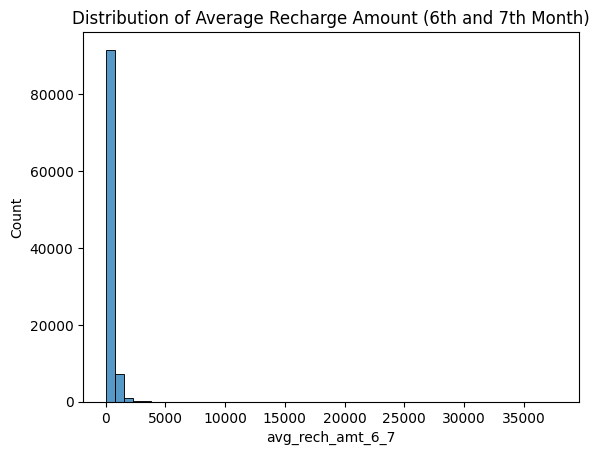

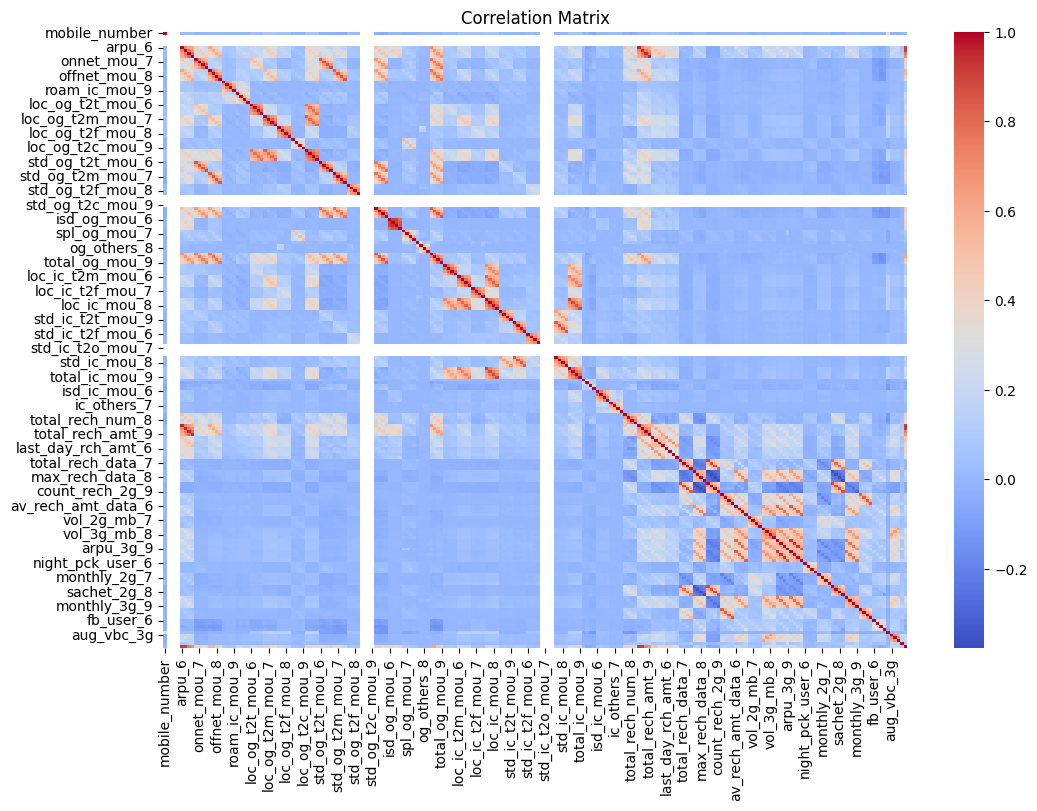

In [9]:
# Distribution of high-value customers
data['avg_rech_amt_6_7'] = (data['total_rech_amt_6'] + data['total_rech_amt_7']) / 2
sns.histplot(data['avg_rech_amt_6_7'], bins=50)
plt.title('Distribution of Average Recharge Amount (6th and 7th Month)')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



##2. Tag churners and remove attributes of the churn phase

In [10]:
# Feature Engineering
# Define high-value customers based on the 70th percentile of the average recharge amount
X_70 = data['avg_rech_amt_6_7'].quantile(0.70)
high_value_customers = data[data['avg_rech_amt_6_7'] >= X_70].copy()

# Tag churners based on the fourth month
high_value_customers.loc[:, 'churn'] = ((high_value_customers['total_ic_mou_9'] == 0) &
                                        (high_value_customers['total_og_mou_9'] == 0) &
                                        (high_value_customers['vol_2g_mb_9'] == 0) &
                                        (high_value_customers['vol_3g_mb_9'] == 0)).astype(int)



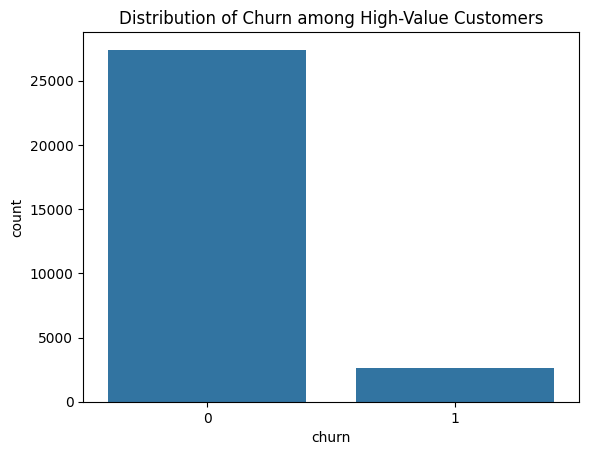

In [11]:
# Remove attributes corresponding to the churn phase and date columns
columns_to_remove = [col for col in high_value_customers.columns if '_9' in col]
high_value_customers.drop(columns=columns_to_remove, inplace=True)

# Select only numeric columns
numeric_cols = high_value_customers.select_dtypes(include=[np.number]).columns.tolist()
high_value_customers = high_value_customers[numeric_cols]

# Distribution of churn among high-value customers
sns.countplot(x='churn', data=high_value_customers)
plt.title('Distribution of Churn among High-Value Customers')
plt.show()

# Define the feature matrix X and the target variable y
X = high_value_customers.drop(columns=['churn'])
y = high_value_customers['churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



##3.Modelling

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8231
           1       0.73      0.36      0.48       773

    accuracy                           0.93      9004
   macro avg       0.84      0.67      0.72      9004
weighted avg       0.92      0.93      0.92      9004

Logistic Regression ROC AUC Score: 0.8946770350250364


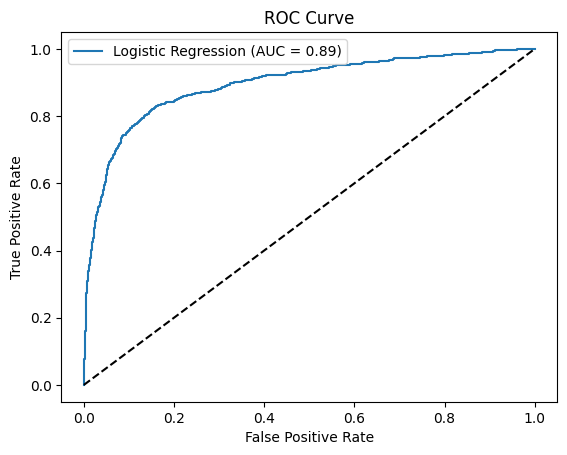

Logistic Regression Feature Importance:
                Feature  Importance
64     loc_ic_t2t_mou_8    0.833671
73         loc_ic_mou_8    0.778513
49         std_og_mou_8    0.775822
97         isd_ic_mou_8    0.769595
79     std_ic_t2m_mou_8    0.625198
..                  ...         ...
89       total_ic_mou_6   -0.524840
112  last_day_rch_amt_8   -0.534694
162          sep_vbc_3g   -0.858029
61       total_og_mou_8   -3.289490
91       total_ic_mou_8   -4.107193

[164 rows x 2 columns]


In [12]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_log_reg_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print(f"Logistic Regression ROC AUC Score: {roc_auc_score(y_test, y_pred_log_reg_proba)}")

# Plot ROC Curve for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_log_reg_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature importance from Logistic Regression
log_reg_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': log_reg.coef_[0]
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance:")
print(log_reg_feature_importance)




/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
              Feature       VIF
0       mobile_number  1.122767
1           circle_id  0.000000
2      loc_og_t2o_mou       NaN
3      std_og_t2o_mou       NaN
4      loc_ic_t2o_mou       NaN
..                ...       ...
159        aug_vbc_3g  3.158597
160        jul_vbc_3g  3.837972
161        jun_vbc_3g  2.946583
162        sep_vbc_3g  1.094686
163  avg_rech_amt_6_7       inf

[164 rows x 2 columns]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8231
           1       0.74      0.48      0.58       773

    accuracy                           0.94      9004
   macro avg       0.85      0.73      0.78      9004
weighted avg       0.93      0.94      0.94      9004

Random Forest ROC AUC Score: 0.9190780507792221


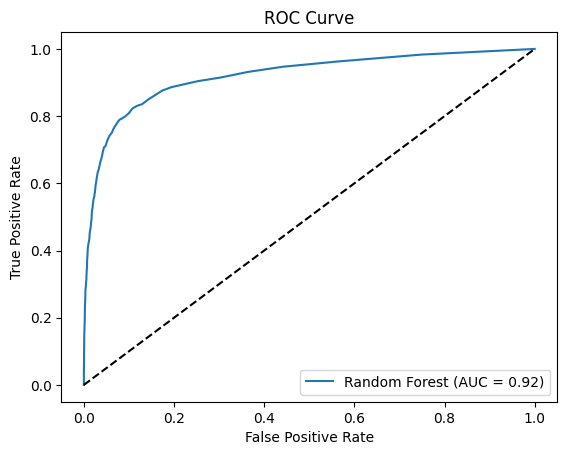

Random Forest Feature Importance:
              Feature  Importance
61     total_og_mou_8    0.056165
91     total_ic_mou_8    0.047302
7              arpu_8    0.039582
19      roam_og_mou_8    0.032182
106  total_rech_amt_8    0.030603
..                ...         ...
46   std_og_t2c_mou_8    0.000000
84   std_ic_t2o_mou_7    0.000000
1           circle_id    0.000000
83   std_ic_t2o_mou_6    0.000000
44   std_og_t2c_mou_6    0.000000

[164 rows x 2 columns]


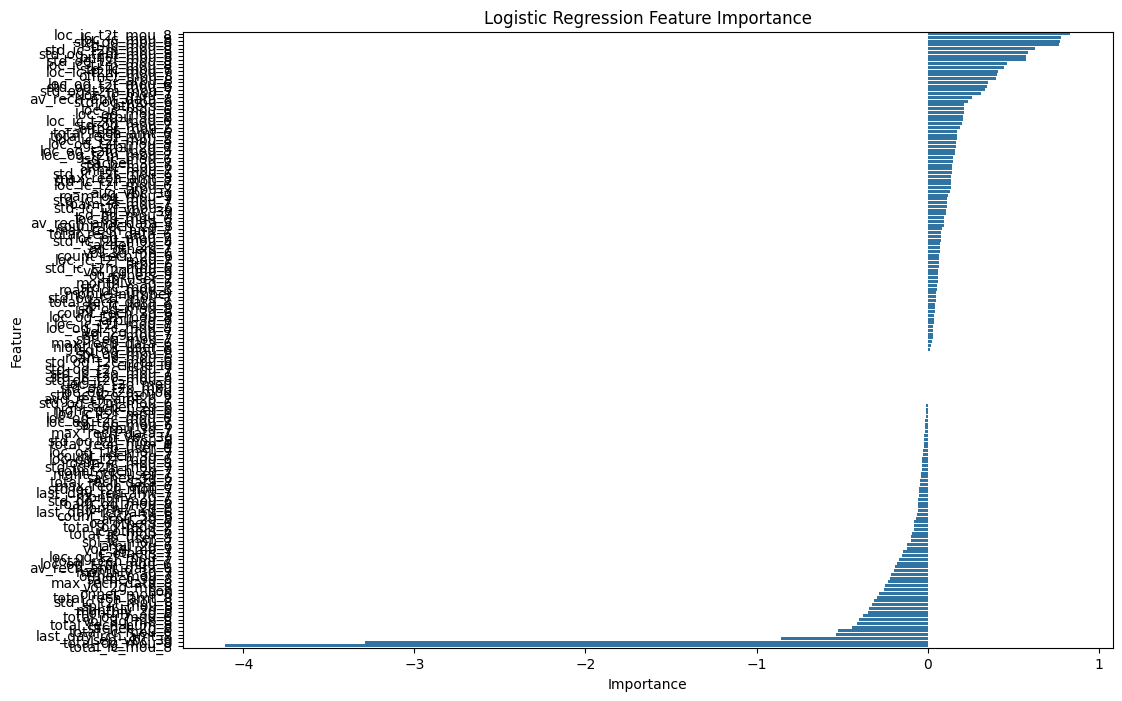

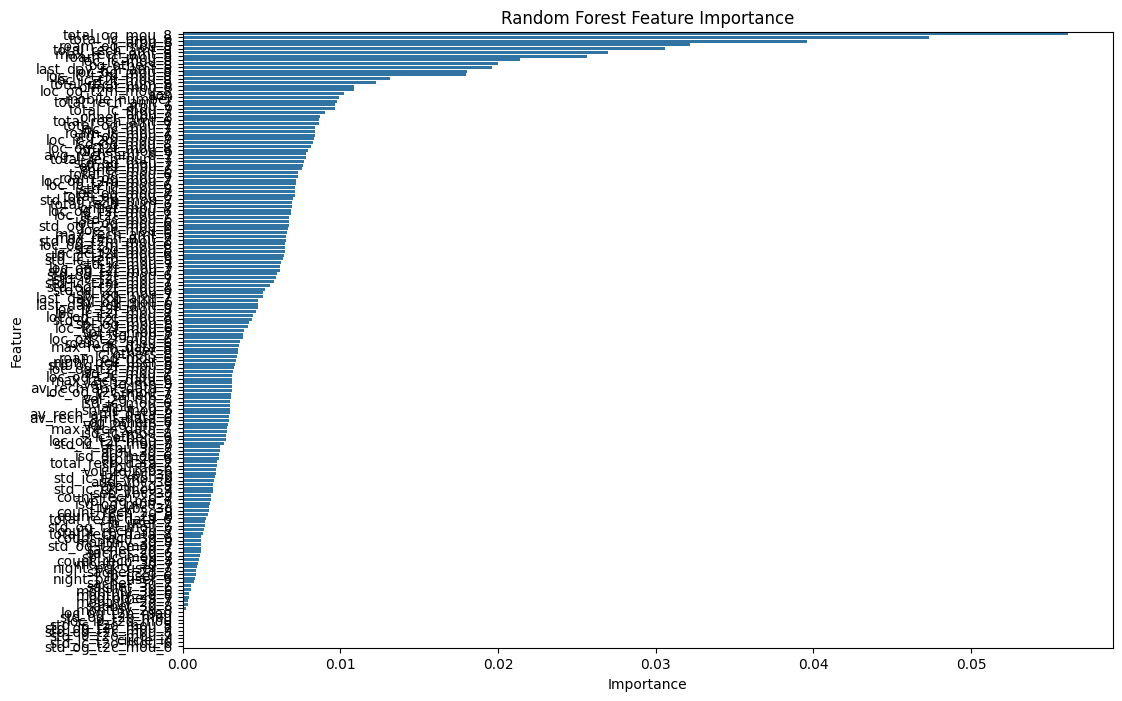

In [13]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factor (VIF):")
print(vif_data)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest ROC AUC Score: {roc_auc_score(y_test, y_pred_rf_proba)}")

# Plot ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, y_pred_rf_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_rf_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature importance from Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_feature_importance)

# Visualization of feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=log_reg_feature_importance)
plt.title('Logistic Regression Feature Importance')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

Top 10 Important Features:
                Feature  Importance
61       total_og_mou_8    0.056165
91       total_ic_mou_8    0.047302
7                arpu_8    0.039582
19        roam_og_mou_8    0.032182
106    total_rech_amt_8    0.030603
109      max_rech_amt_8    0.026946
16        roam_ic_mou_8    0.025653
73         loc_ic_mou_8    0.021368
58          og_others_8    0.019981
112  last_day_rch_amt_8    0.019614


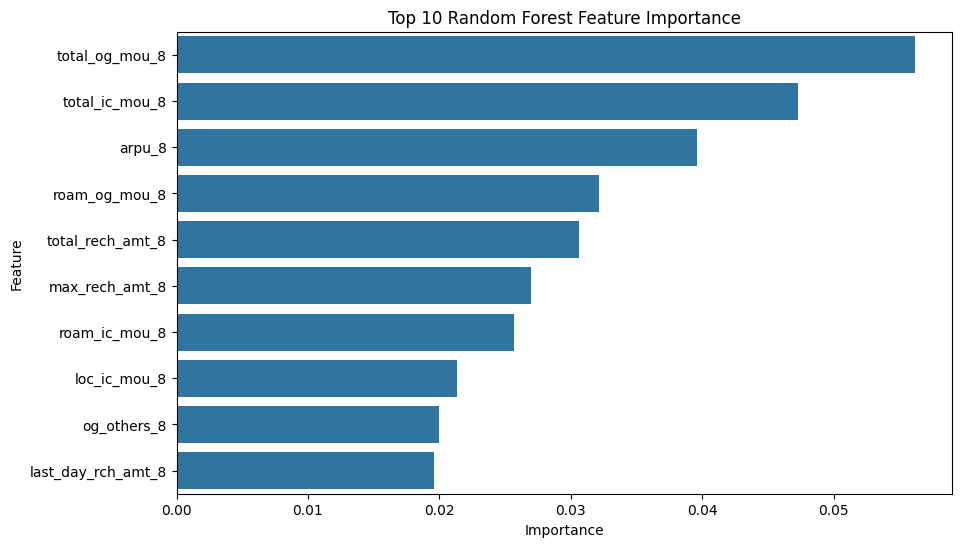

In [14]:
# Display top 10 features
top_features = rf_feature_importance.head(10)
print("Top 10 Important Features:")
print(top_features)

# Visualization of top 10 feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Random Forest Feature Importance')
plt.show()
